#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose 

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

import catboost
from catboost import cv
from catboost import CatBoostRegressor

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore")

In [2]:
#Создание признаков
def making_features(df,count,roll):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['hour'] = df.index.hour

    for i in range(1,count+1):
        df['lag_{}'.format(i)] = df['num_orders'].shift(i)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(roll).mean()
    

In [3]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0],parse_dates=[0])

In [4]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
#Проверка на хронологический порядок
print(df.index.is_monotonic)

True


Данные расположены в хронологическом порядке дополнительная работа над этим не требуется

In [6]:
df = df.resample('1H').sum()
df['num_orders'] = df['num_orders'].astype(int)

In [7]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

<AxesSubplot:xlabel='datetime'>

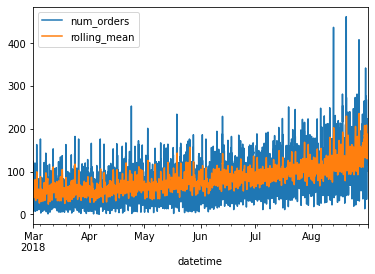

In [8]:
#Создание скользящего среднего за 8 часов
df['rolling_mean'] = df.rolling(8).mean()
df.plot()

Исходя из графика мы можем видеть, что к лету среднее количество заказов в час увеличивается

<AxesSubplot:xlabel='datetime'>

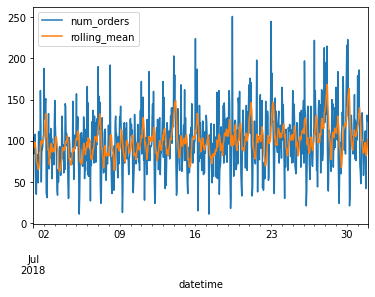

In [9]:
df['2018-07'].plot()

Для анализа месячных данных возьмем июль, как мы можем видеть из графика в течение всего месяца не наблюдается значительных отличий в количестве заказов исходя из дня

<AxesSubplot:xlabel='datetime'>

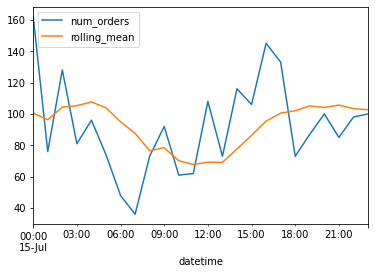

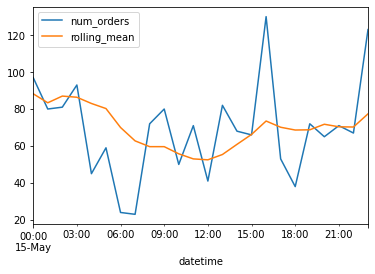

In [10]:
df['2018-07-15'].plot()
df['2018-05-15'].plot()

Для анализа дневного тренда возьмем данные за 15 июля и 15 мая. Как мы можем видеть есть тенденция к тому, что наибольшее количество заказанных такси приходится на 3-6 часов утра, в то время как минимальное количество заказов на 9-13 часов

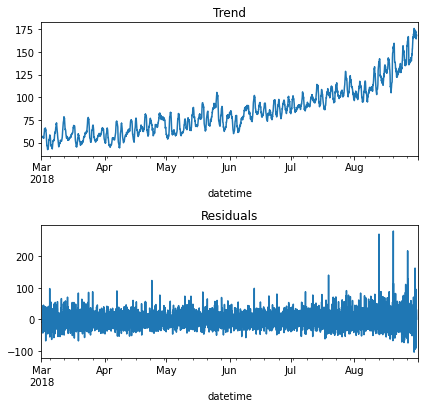

In [11]:
df_2 = df.drop('rolling_mean',axis=1)
decomposed = seasonal_decompose(df_2)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Мы видим что тренд идет к увеличению количества заказов

Text(0.5, 1.0, 'Seasonality')

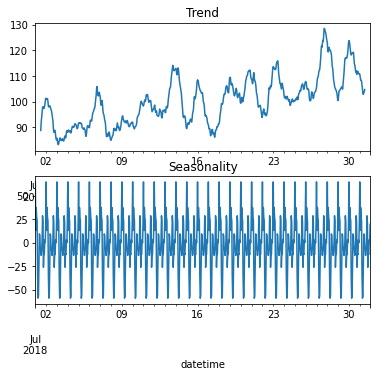

In [12]:
decomposed = seasonal_decompose(df_2['2018-07'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

Text(0.5, 1.0, 'Seasonality')

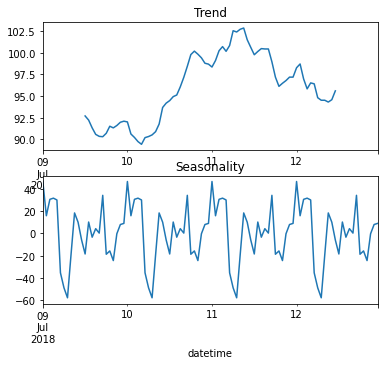

In [15]:
decomposed = seasonal_decompose(df_2['2018-07-09':'2018-07-12'])
#decomposed = seasonal_decompose(df_2)['2018-07-09':'2018-07-12']

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

Исходя из графиков мы также видим сезонность, что поздно ночью - рано утром наибольшее количество заказов такси, после чего количество заказов минимально

In [16]:
df

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN
...,...,...
2018-08-31 19:00:00,136,163.500
2018-08-31 20:00:00,154,165.750
2018-08-31 21:00:00,159,164.875


<AxesSubplot:xlabel='datetime'>

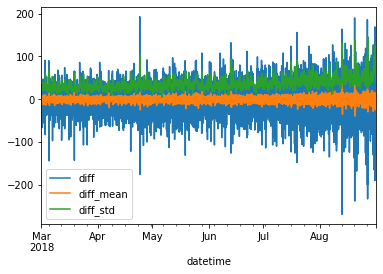

In [17]:
df_2 = df.copy()
df_2['diff'] = df_2['num_orders'] - df_2['num_orders'].shift()
df_2['diff_mean'] = df_2['diff'].rolling(8).mean()
df_2['diff_std'] = df_2['diff'].rolling(8).std()
df_2 = df_2.drop(['rolling_mean','num_orders'],axis=1)
df_2.plot()

Исходя из разности временного ряда можем видеть, что в среднем количество поездок не сильно изменяется за 1 час

## Обучение

In [18]:
df = df.drop(['rolling_mean'],axis=1)

In [19]:
making_features(df,6,8)

In [20]:
df

,num_orders,month,day,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,167.375
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,163.500
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,165.750


In [21]:
df = df.dropna()
train, test = train_test_split(df, shuffle=False, test_size=0.1)

train_features = train.drop('num_orders',axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders',axis=1)
test_target = test['num_orders']



Для прогнозирования временного ряда будем использовать 3 модели (линейную регрессию, модель решающего дерева, леса)

In [22]:
model_lin = LinearRegression()
lin_params = {}
time_split = TimeSeriesSplit()
lin_grid = GridSearchCV(model_lin,lin_params, cv=time_split.split(train_features),n_jobs=-1,verbose=True,scoring='neg_root_mean_squared_error')
lin_grid.fit(train_features,train_target)
print('Лучшая модель линейной регрессии показала результат:',lin_grid.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Лучшая модель линейной регрессии показала результат: -31.51456521840297


In [23]:
tree_model = DecisionTreeRegressor(random_state=12345)
tree_params = {'max_depth': range(1,30)}
time_split = TimeSeriesSplit()
tree_grid = GridSearchCV(tree_model, tree_params, cv=time_split.split(train_features),n_jobs=-1,verbose=True,scoring='neg_root_mean_squared_error')
tree_grid.fit(train_features,train_target)
print('Лучшая модель дерева показала результат:',tree_grid.best_score_,' при глубине дерева =', tree_grid.best_params_)

Fitting 5 folds for each of 29 candidates, totalling 145 fits
Лучшая модель дерева показала результат: -28.900212660739534  при глубине дерева = {'max_depth': 8}


In [25]:
forest_model = RandomForestRegressor(random_state=12345)
forest_params = {'max_depth': range(9,20,1), 'n_estimators': range(90,120,10)}
time_split = TimeSeriesSplit()
forest_grid = GridSearchCV(forest_model, forest_params, cv=time_split.split(train_features),n_jobs=-1,verbose=True,scoring='neg_root_mean_squared_error')
forest_grid.fit(train_features,train_target)
print('Лучшая модель леса показала результат:',forest_grid.best_score_,' при глубине дерева и количестве деревьев =',
      forest_grid.best_params_)

Fitting 5 folds for each of 33 candidates, totalling 165 fits
Лучшая модель леса показала результат: -25.208204771810244  при глубине дерева и количестве деревьев = {'max_depth': 18, 'n_estimators': 110}


После обучения и проверки всех моделей лучшей моделью оказалась модель случайного леса с глубиной 18 и количеством деревьев - 110

## Тестирование

In [26]:
predictions = forest_grid.predict(test_features)
print(mean_squared_error(test_target,predictions,squared=False))

44.96932313847577


<AxesSubplot:xlabel='datetime'>

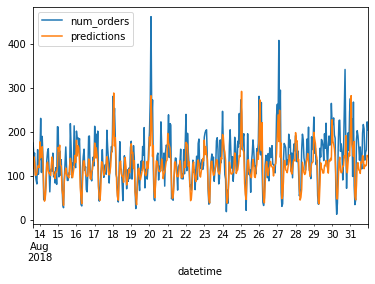

In [36]:
test_target = pd.DataFrame(test_target)
test_target['predictions'] = predictions
test_target.plot()

Итоговый результат самой лучшей модели на тестовой выборке показал RMSE-score равный 45 и исходя из графика мы видим, что линия предсказания довольно близка к реальному результату и значимо отличается только в те моменты когда реальные результаты слишком высоки